In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [6]:
boston = load_boston()

In [16]:
X, y = boston.data, boston.target
df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]),
                  columns=boston.feature_names.tolist()+["target"])
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# 前処理

外れ値検出

スミルノフグラブス（Simirnov-Grubbs）検定
- [スミルノフ・グラブス検定](https://gist.github.com/c-bata/2b2c16590ea4dcd4e70c)
- [実装コード](http://blog.graviness.com/?eid=949269#sequel)

__ただし，スミルノフグラブス検定は正規分布を仮定した手法なので正規分布からかけ離れた分布のデータに利用すると、観測値の殆どが外れ値になってしまうこともあるので注意__

In [8]:
import scipy.stats as stats

def smirnov_grubbs(data, alpha):
    """
    Generate outlier-removed data with Smirnov-Grubbs.

    Parameters:
    -----------------
    data: array_like
       Numeric data values.
    alpha: float
       Significance level. (two-sided)

    Returns:
    -----------------
      index: list
          外れ値として捨てたデータの，元のデータでのindex
    """
    if not isinstance(data, pd.Series):
        x = pd.Series(data)
    else:
        x = data
    
    o, index = [], []  # 外れ値のデータ, 外れ値のindex
    while True:
        n = len(x)  # データ数
        t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)  # 自由度 n - 2 のt分布の α / 2*n × 100 パーセンタイル 
        tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)  # 有意点
        i_min, i_max = x.idxmin(), x.idxmax()
        myu, std = np.mean(x), np.std(x, ddof=1)  # 平均 と 不偏標準偏差
        # 平均より離れているほうで検定を行う
        i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
        tau_far = np.abs(x[i_far] - myu) / std

        if tau_far < tau: break  # 帰無仮説を棄却できなければ終了
        x = x.drop(i_far) # 帰無仮説が棄却できれば外れ値を捨てる
        index.append(i_far)
    return index

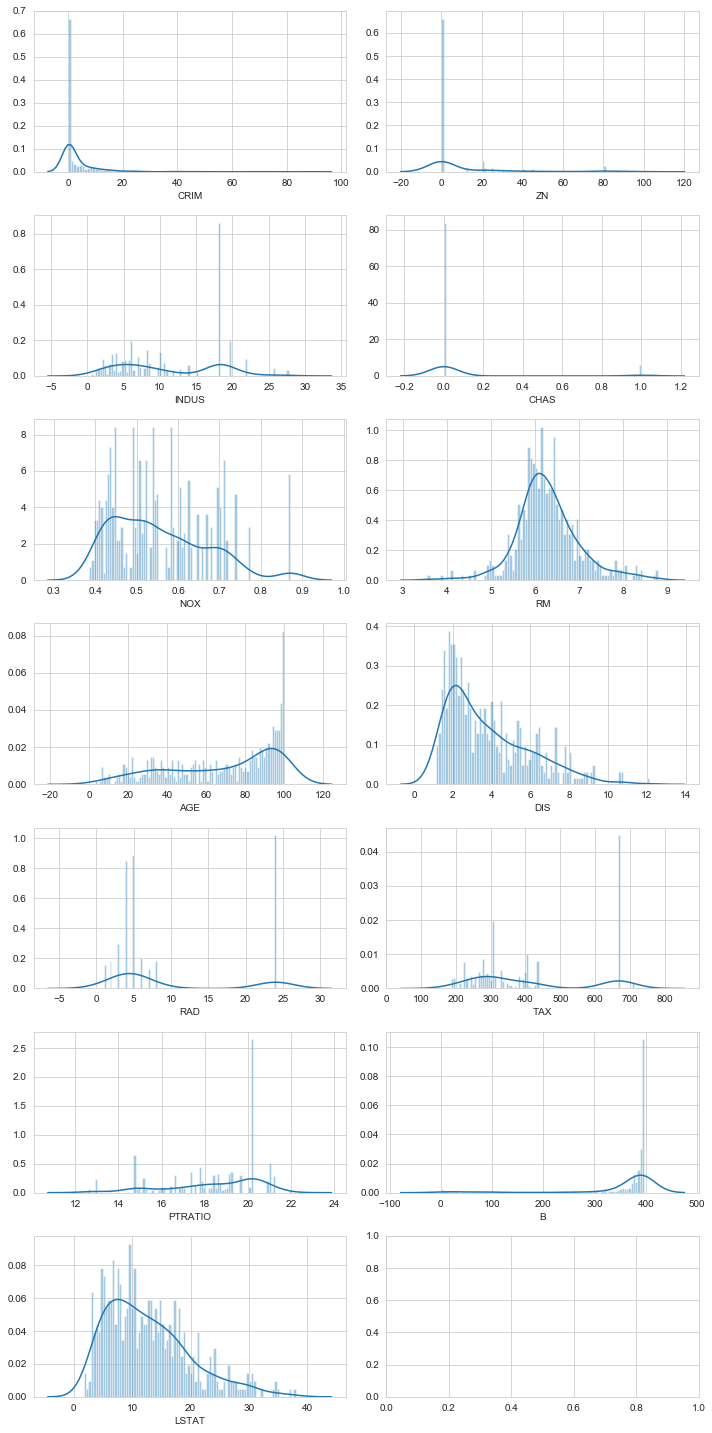

In [10]:
# ヒストグラムから正規分布に従うかを判断
import seaborn as sns
sns.set_style("whitegrid")
fig, axex = plt.subplots(7, 2, figsize=(10, 20))
for i, ax in enumerate(axex.flatten()):
    if i==13: break
    sns.distplot(df.iloc[:, i], ax=ax, bins=90)
plt.tight_layout()

In [33]:
# 外れ値除去
# 危険率を0.05とする
alpha = 0.05
index = set()
for column in ["RM"]:
    index |= set(smirnov_grubbs(df[column], alpha=alpha))

In [34]:
df_pre = df.drop(index=index, axis=1)
print("データ数:", len(df_pre))

データ数: 505


In [35]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test =\
    train_test_split(df_pre.iloc[:, :-1], df_pre.iloc[:, -1],
                     test_size=0.2, random_state=0)
print("学習データ数:", len(X_train), "テストデータ数:", len(X_test))

学習データ数: 404 テストデータ数: 101


In [36]:
# データを標準化: 平均 0 分散 1
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_pre = ss.fit_transform(X_train)
X_test_pre = ss.transform(X_test)

# 重回帰分析

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
lr = LinearRegression()
lr.fit(X=X_train_pre, y=y_train)

/Users/yohei/.pyenv/versions/3.6.5/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
lr.